# Introduction

# Preparatory analysis

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [139]:
data = pd.read_csv('data/diabetic_data.csv')

In [140]:
data.rename(columns={'glyburide-metformin':'glyburide_metformin', 'glipizide-metformin': 'glipizide_metformin', 
             'glimepiride-pioglitazone': 'glimepiride_pioglitazone', 'metformin-rosiglitazone': 'metformin_rosiglitazone', 
             'metformin-pioglitazone': 'metformin_pioglitazone'}, inplace=True)

In [141]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


## Counting missing values for each feature

### Nan Values

In [142]:
data.shape

(101766, 50)

In [143]:
na_values = data.isna().sum(axis=0)

print(na_values[na_values > 0]/len(data) * 100)

max_glu_serum    94.746772
A1Cresult        83.277322
dtype: float64


Apparently, max_glu_serum and A1Cresults are the only features with 'Nan' values. We can easily drop these columns, as these features are categorical so they cannot be inferred in any way. 


In [144]:
data['max_glu_serum'].unique()

array([nan, '>300', 'Norm', '>200'], dtype=object)

In [145]:
data['A1Cresult'].unique()

array([nan, '>7', '>8', 'Norm'], dtype=object)

In [146]:
data = data.drop(columns=['max_glu_serum', 'A1Cresult'])

### Other missing values

Taking a look at the datasaet, it is clear that for some features missing values are indicated by a question mark rathen than being nan values. Let's count missing values for each column

In [147]:
for col in data.columns:
    missing_values = data.loc[data[col] == '?', col].value_counts()
    if len(missing_values.values > 0):
        print(col, missing_values.values/len(data) * 100)

race [2.23355541]
weight [96.85847926]
payer_code [39.55741603]
medical_specialty [49.0822082]
diag_1 [0.02063558]
diag_2 [0.35178743]
diag_3 [1.39830592]


From the results above, we find that the feature 'weight' is available only for 3% of the observations! This column can be dropped. We also find that 49% of observations do not have values for medical_speciality and 39% do not have values for payer_code. These two are both categorical variables, so we cannot use the mean or other statistics to replace missing values. So, they can easily be dropped
diag_1, diag_2 and diag_3 are diagnosis so they cannot be inferred. In a classification setting these features can cleary be useful. Suppose the primary diagnosis is correct: intuitevely, a patient with a correct diagnosis has a less probability of returning to the hospital rather than a patient with n incorrect diaagnosis. Rather than drop the columns it is wiser to drop the observations with missing diagnosis.

In [148]:
data = data.drop(columns=['weight', 'payer_code', 'medical_specialty'])

In [149]:
data.shape

(101766, 45)

In [150]:
data.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Data is now ready for the analysis pipeline!

## Renaiming some columns

To avoid potential failure when using statsmodel, we rename the columns that contains a '-' in their name.

In [151]:
data.rename(columns={'glyburide-metformin':'glyburide_metformin', 'glipizide-metformin': 'glipizide_metformin', 
             'glimepiride-pioglitazone': 'glimepiride_pioglitazone', 'metformin-rosiglitazone': 'metformin_rosiglitazone', 
             'metformin-pioglitazone': 'metformin_pioglitazone'}, inplace=True)

## Removing outliers

In [152]:
data[data['gender'] == 'Unknown/Invalid']
data = data.drop(index=[30506, 75551, 82573])

# Exploratory data analysis

## What is the most frequent readmission type?

In [153]:
freqs = data['readmitted'].value_counts(normalize=True).sort_index()
print(freqs)

readmitted
<30    0.111602
>30    0.349292
NO     0.539106
Name: proportion, dtype: float64


<Axes: xlabel='readmitted'>

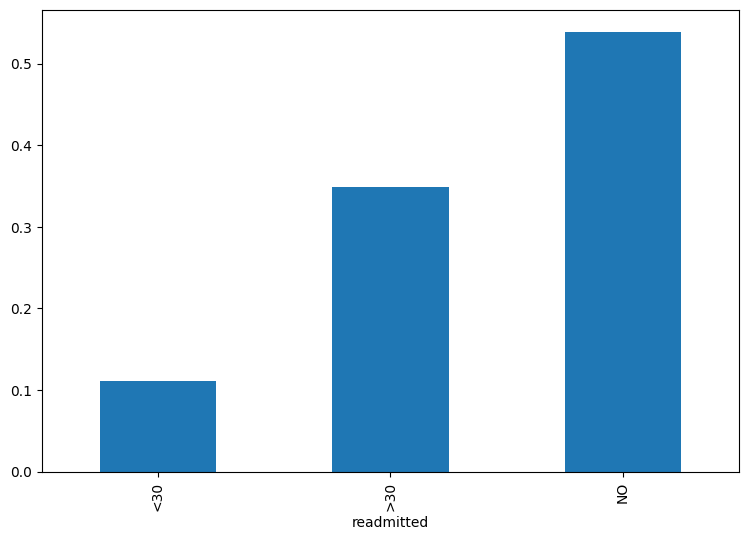

In [154]:
freqs.plot.bar(figsize=(9, 6))

The dataset is very imbalanced. Only 10% of observation represents class "readmitted within 30 days". 

In [155]:
#data['readmitted'].plot.bar()

## What is the distribution of gender between readmissions?

## Distribution of gender

In [156]:
data['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [157]:
freqs = data['gender'].value_counts(normalize=True)
print(freqs)

gender
Female    0.537602
Male      0.462398
Name: proportion, dtype: float64


<Axes: xlabel='gender'>

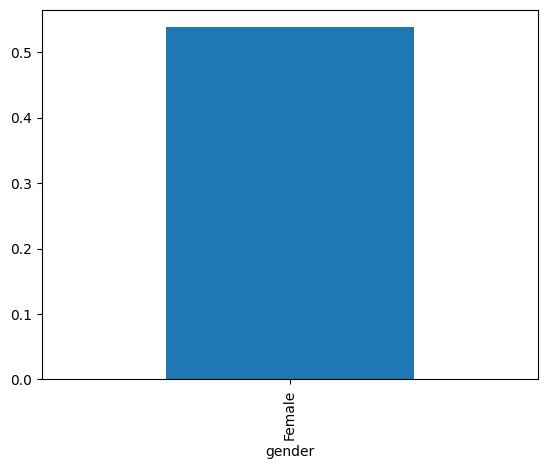

In [158]:
freqs[0:-1].plot.bar()

Let's count how many patients with 'unknown/invalid' gender are there in the dataset

In [159]:
data['gender'].value_counts().sort_index()

gender
Female    54708
Male      47055
Name: count, dtype: int64

## Distribution of gender between readmissions

<Axes: xlabel='gender'>

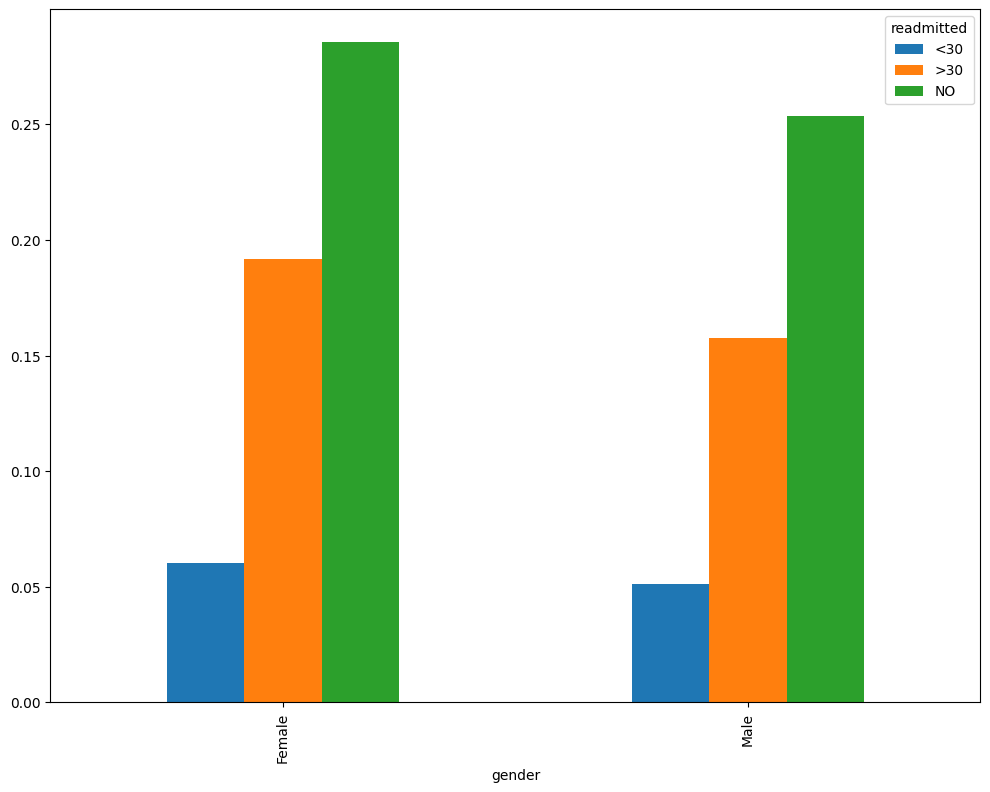

In [160]:
d = data[['gender', 'readmitted']]

cont_table = pd.crosstab(index=d['gender'], columns=data['readmitted'], normalize=True)

cont_table.plot.bar(figsize=(12, 9))

<Axes: xlabel='gender'>

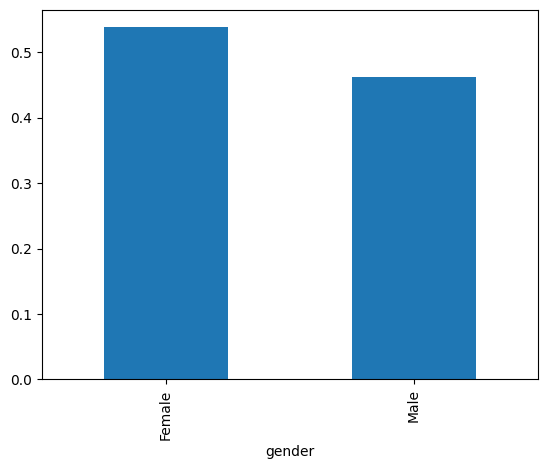

In [161]:
freqs.plot.bar()

## Distribution of age

ecdf = data['age'].value_counts(normalize=True).sort_index().cumsum()

plt.figure(figsize=(12, 8))
plt.title('Empirative Cumulative Distribution Function of Age')
plt.grid()
plt.plot(ecdf.index, ecdf.values)

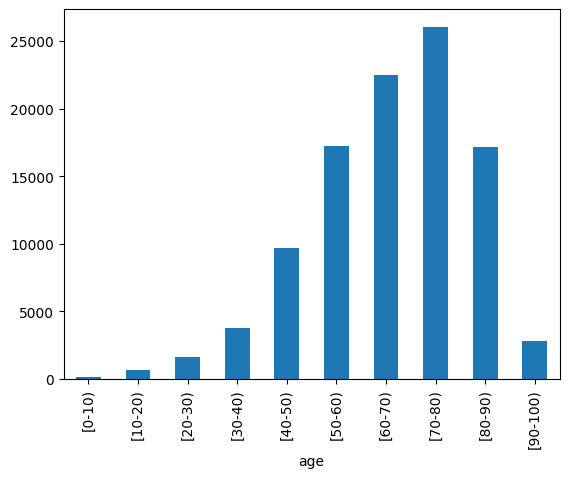

In [162]:
freqs = data['age'].value_counts().sort_index().plot.bar()

In [163]:
cont_table = pd.crosstab(index=data['age'], columns=data['readmitted'], normalize=True)
cont_table

readmitted,<30,>30,NO
age,,,
[0-10),0.000029,0.000255,0.001297
[10-20),0.000393,0.002201,0.004196
[20-30),0.002319,0.005012,0.008952
[30-40),0.004167,0.011664,0.021265
[40-50),0.010092,0.032212,0.052868
[50-60),0.016391,0.058145,0.095035
[60-70),0.024587,0.077602,0.118737
[70-80),0.030158,0.093108,0.132877
[80-90),0.020420,0.061152,0.087419


<Axes: xlabel='age'>

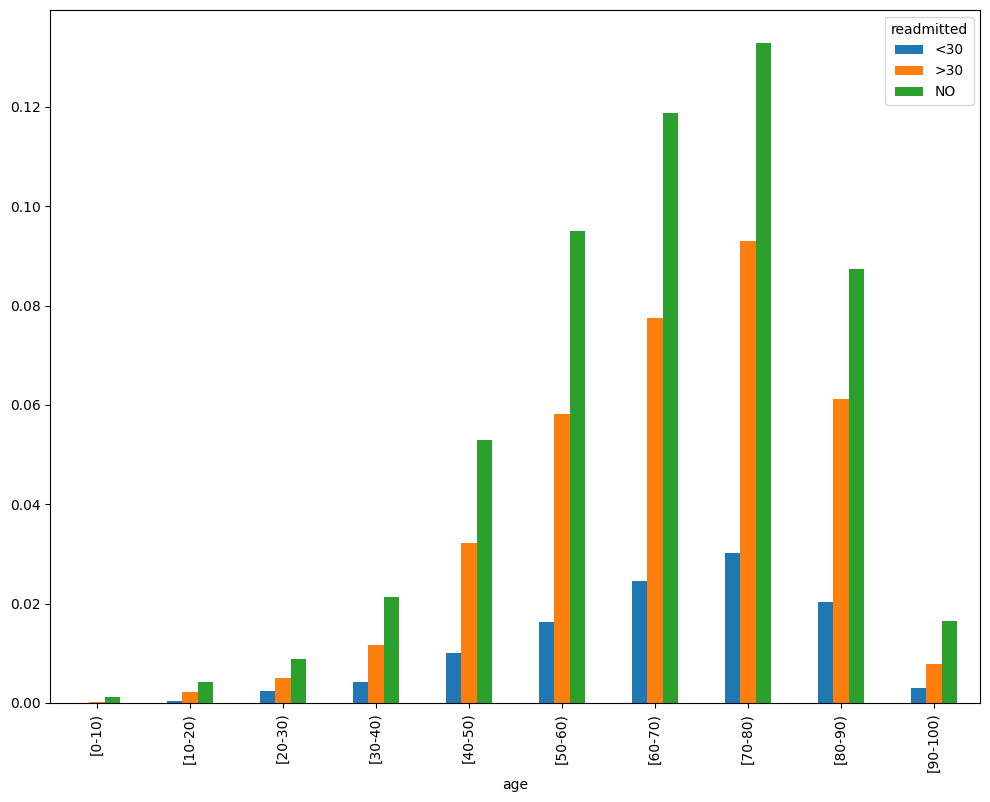

In [164]:
cont_table.plot.bar(figsize=(12, 9))

From the plot above, we can say that the distribution of age is similar between readmisssions types.

# Preparing data for further analysis

In [165]:
data.replace({'readmitted': {'NO': 0, '>30': 1, '<30': 2}}, inplace=True)

C:\Users\Raffaele\AppData\Local\Temp\ipykernel_20352\3738235945.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({'readmitted': {'NO': 0, '>30': 1, '<30': 2}}, inplace=True)


Let's drop some variables about administrative data

In [166]:
data.drop(columns=['encounter_id', 'patient_nbr', 'age', 'race', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'examide', 'citoglipton',
                          'diag_1', 'diag_2', 'diag_3'], inplace=True)

Variables "citoglipton" and "examide" have identical values for each observations. so we need to remove them in order to build models for inferential or predictive analysis

# Inferential Analysis

## What is the average time in hospital?

In [167]:
mean = data['time_in_hospital'].mean()
print(mean)

4.396018199149003


From the results above, we find that the average time in hospital is 4 days. Is this due to chance or is it statistically significant? Let's run a statistical test and find out.

In [168]:
t, p = stats.ttest_1samp(data['time_in_hospital'], mean)
alpha = 0.05
print("P value: ", p, "\nAlpha: ", alpha)

P value:  1.0 
Alpha:  0.05


The p value is greater than the significance level, so we cannot reject the null hypothesis. <br>
This means that data do not provide enough evidence to say that the true time in hospital differs from 4 and an half day.

<Axes: >

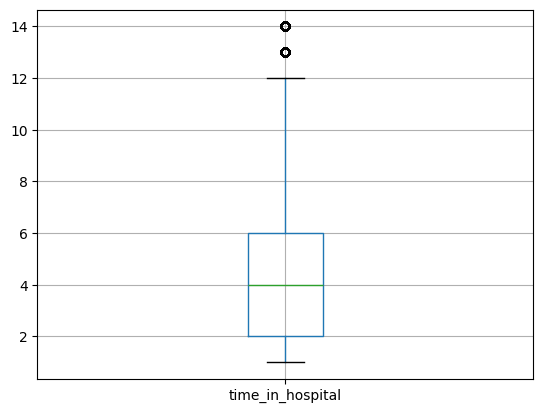

In [169]:
data.boxplot(column=['time_in_hospital'])

From the box plot above, we notice that values 13 and 14 are outliers. The median value is 4 and the third quantile is 6. 

## What is the average time in hospital between readmission classes?

In [170]:
not_readmitted = data.loc[data['readmitted'] == 0, 'time_in_hospital']
mean_not_readmitted = not_readmitted.mean()
print(mean_not_readmitted)

4.254479502743297


In [171]:
readmitted = data.loc[data['readmitted'] != 0, 'time_in_hospital']
mean_readmitted = data.loc[data['readmitted'] != 0, 'time_in_hospital'].mean()
print(mean_readmitted)

4.56157519935184


Again, is this due to chance or is it statistically significant? Let's run a statistical test to see if we can reject the hypothesis that the two means are equal. 

In [172]:
t, p = stats.ttest_ind(readmitted, not_readmitted)
alpha = 0.05
print("P value: ", p, "\nAlpha: ", alpha)

P value:  3.1662864432201493e-60 
Alpha:  0.05


We can reject the null hyphothesis. It is safe to say that the two populations mean are different. 
Let's study the relationship between time_in_hospital and readmitted, using logistic regression.

Let's use a boxplot to study the distribution of time_in_hospital between readmissions.

<Axes: title={'center': 'time_in_hospital'}, xlabel='readmitted'>

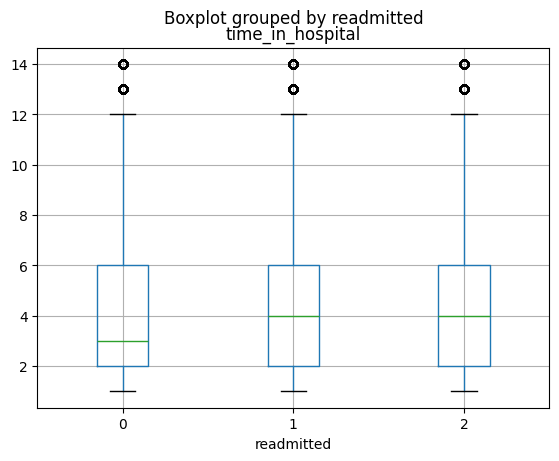

In [173]:
data.boxplot(by='readmitted', column='time_in_hospital') #todo: cambiare titolo

For classes 1 and 2, bloxplots are indentical. For class 0, the median is lower than the other two. This means that the distribution of time_in_hospital for patients of class 0 is not symmetrical.

In [174]:
## Altro?

## Simple logit regression

Let's fit a logistic regressor to study the relationship between time_in_hospital and readmitted. Let's see if an increase of the variable "time_in_hospital" leads to an increase in the probability that a patient will be readmitted or not. 

In [175]:
from statsmodels.formula.api import logit, mnlogit

### Preparing the data

To do this, it is not necessary to use three class of readmissions, instead it sufficient to know if a patient has been readmitted or not.

In [176]:
data['readmitted'].unique()

array([0, 1, 2])

In [177]:
data.replace({'readmitted': {'NO': 0, '>30': 1, '<30': 2}}, inplace=True)

In [178]:
view = data.replace({'readmitted': {2: 1}})

In [179]:
view['readmitted'].unique()

array([0, 1])

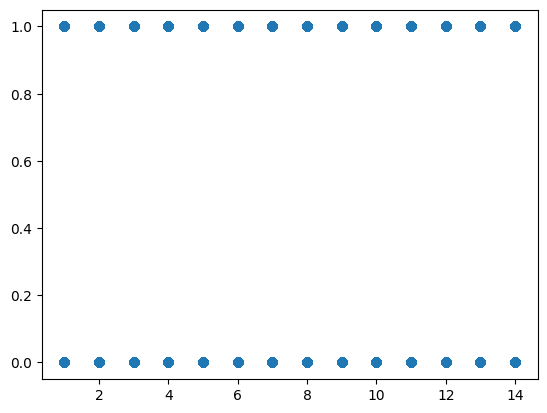

In [180]:
plt.scatter(x=view['time_in_hospital'], y=view['readmitted'])

### Simple logit regression

We can now fit a simple logit regressor

In [181]:
model = logit('readmitted ~ time_in_hospital', view).fit()

Optimization terminated successfully.
         Current function value: 0.688772
         Iterations 4


In [182]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               101763
Model:                          Logit   Df Residuals:                   101761
Method:                           MLE   Df Model:                            1
Date:                Sat, 01 Mar 2025   Pseudo R-squ.:                0.001903
Time:                        16:45:33   Log-Likelihood:                -70092.
converged:                       True   LL-Null:                       -70225.
Covariance Type:            nonrobust   LLR p-value:                 4.513e-60
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.3084      0.011    -27.461      0.000      -0.330      -0.286
time_in_hospital     0.0344      0.002     16.331      0.000       0.030       0.039
====================================================================================
"""

The pseudo-R^2 is very small: the model do not explain well the data.

In [183]:
np.exp(-0.3085)

np.float64(0.7345479521991701)

when time_in_hospital is set to 0, unrealistically, the odds of a patient being readmitted rather than not is 0.73. 

In [184]:
np.exp(0.0344)

np.float64(1.0349985233486143)

Without considering other variables, an extra day in hospital corresponds to a multiplicative increase in the odds of a patient being readmitted rather than not of 1.034. That is, if a patient spend an extra day in the hospital, the odds of being readmitted increases by a (1-1.034)*100 = 3.4%

## Simple multivariate logit regressor

In [185]:
model = mnlogit('readmitted ~ time_in_hospital', data).fit()

Optimization terminated successfully.
         Current function value: 0.943567
         Iterations 6


In [186]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:             readmitted   No. Observations:               101763
Model:                        MNLogit   Df Residuals:                   101759
Method:                           MLE   Df Model:                            2
Date:                Sat, 01 Mar 2025   Pseudo R-squ.:                0.001736
Time:                        16:45:34   Log-Likelihood:                -96020.
converged:                       True   LL-Null:                       -96187.
Covariance Type:            nonrobust   LLR p-value:                 3.001e-73
====================================================================================
    readmitted=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.5537      0.012    -45.590      0.000      -0.577      -0.530
time_in_hospital     0.0274      0.002     11.964      0.000       0.023       0.032
------------------------------------------------------------------------------------
    readmitted=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.8253      0.019    -98.340      0.000      -1.862      -1.789
time_in_hospital     0.0556      0.003     16.817      0.000       0.049       0.062
====================================================================================
"""

In [187]:
np.exp(0.0556)

np.float64(1.0571747292596514)

This model is not reliable due to an imbalance of classes.

## Multiple logistic regression

Let's define a function that build the formula automatically

In [188]:
def buildFormula(columns):
    formula = 'readmitted ~ ' + columns[0]
    
    for s in columns[1:-1]:
        formula = formula + ' + ' + s
        
    return formula

In [189]:
view = data.replace({'readmitted': 2}, 1)

In [190]:
#view['age'] = view['age'].replace({'[0-10)': 5, '[10-20)': 15, '[20-30)': 25,
#                             '[30-40)': 35, '[40-50)': 45, '[50-60)': 55,
#                             '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95,
#                            })

We need to introduce dummy variables for each categorical variable in order to build a logit regressor

In [191]:
cols = np.concatenate([[view.columns[0]], view.columns[9:-1]])
view = pd.get_dummies(view, columns=cols, drop_first=True, dtype=np.uint8)

## Removing correlated categorical variables using Cramer's V statistic

In [192]:
from scipy.stats.contingency import association

In [193]:
view.dtypes

time_in_hospital                   int64
num_lab_procedures                 int64
num_procedures                     int64
num_medications                    int64
number_outpatient                  int64
number_emergency                   int64
number_inpatient                   int64
number_diagnoses                   int64
readmitted                         int64
gender_Male                        uint8
metformin_No                       uint8
metformin_Steady                   uint8
metformin_Up                       uint8
repaglinide_No                     uint8
repaglinide_Steady                 uint8
repaglinide_Up                     uint8
nateglinide_No                     uint8
nateglinide_Steady                 uint8
nateglinide_Up                     uint8
chlorpropamide_No                  uint8
chlorpropamide_Steady              uint8
chlorpropamide_Up                  uint8
glimepiride_No                     uint8
glimepiride_Steady                 uint8
glimepiride_Up  

In [194]:
def buildVMatrix(df):
    l = []
    cat_vars = df.select_dtypes(include=['uint8']).columns
    v_mat = pd.DataFrame(index = cat_vars, columns= cat_vars)

    for var_one in cat_vars:
        for var_two in cat_vars:
            v = association(pd.crosstab(view[var_one], view[var_two]))
            v_mat.loc[var_one, var_two] = v
            
            if var_one != var_two and v >= 0.9:
                el = [var_one, var_two]
                el.sort()
                
                #usare un set
                if el[1] not in l:
                    l.append(el[1])
    return l
            

In [195]:
#vars_to_drop = buildVMatrix(view)
#view = view.drop(columns=vars_to_drop)

In [196]:
#vars_to_drop

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["feature"] = view.columns.drop('readmitted')
vif["VIF"] = [variance_inflation_factor(view.drop(columns='readmitted').values, i) for i in range(view.shape[1]-1)]

print(vif.sort_values(by="VIF", ascending=False))
#
# view = view.drop(columns=s.iloc[0:19]['feature'].values)

In [197]:
model = logit(buildFormula(view.columns.drop('readmitted')), view).fit()

         Current function value: 0.653151
         Iterations: 35


c:\Users\Raffaele\anaconda3\envs\fad\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [198]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               101763
Model:                          Logit   Df Residuals:                   101704
Method:                           MLE   Df Model:                           58
Date:                Sat, 01 Mar 2025   Pseudo R-squ.:                 0.05352
Time:                        16:45:37   Log-Likelihood:                -66467.
converged:                      False   LL-Null:                       -70225.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -1.3862   1778.058     -0.001      0.999   -3486.315    3483.543
time_in_hospital                    0.0119      0.003      4.653      0.000       0.007       0.017
num_lab_procedures                  0.0013      0.000      3.720      0.000       0.001       0.002
num_procedures                     -0.0478      0.004    -11.259      0.000      -0.056      -0.039
num_medications                     0.0006      0.001      0.536      0.592      -0.001       0.003
number_outpatient                   0.0844      0.006     14.029      0.000       0.073       0.096
number_emergency                    0.2136      0.012     17.425      0.000       0.190       0.238
number_inpatient                    0.3707      0.007     53.373      0.000       0.357       0.384
number_diagnoses                    0.0819      0.004     22.692      0.000       0.075       0.089
gender_Male                        -0.0524      0.013     -3.983      0.000      -0.078      -0.027
metformin_No                       -0.0105      0.087     -0.121      0.904      -0.182       0.160
metformin_Steady                   -0.0591      0.087     -0.675      0.499      -0.231       0.112
metformin_Up                       -0.1495      0.107     -1.395      0.163      -0.359       0.060
repaglinide_No                     -0.0582      0.306     -0.190      0.849      -0.659       0.542
repaglinide_Steady                  0.2275      0.311      0.731      0.465      -0.382       0.837
repaglinide_Up                     -0.1024      0.364     -0.281      0.778      -0.815       0.611
nateglinide_No                     -0.0560      0.612     -0.091      0.927      -1.256       1.144
nateglinide_Steady                  0.0772      0.617      0.125      0.901      -1.133       1.287
nateglinide_Up                     -0.1737      0.751     -0.231      0.817      -1.646       1.299
chlorpropamide_No                  13.6182   1418.349      0.010      0.992   -2766.294    2793.531
chlorpropamide_Steady              13.8500   1418.349      0.010      0.992   -2766.063    2793.763
chlorpropamide_Up                  15.4967   1418.349      0.011      0.991   -2764.417    2795.410
glimepiride_No                     -0.1372      0.149     -0.923      0.356      -0.429       0.154
glimepiride_Steady                 -0.0158      0.151     -0.105      0.917      -0.312       0.280
glimepiride_Up                     -0.2054      0.187     -1.097      0.273      -0.572       0.162
acetohexamide_Steady               19.8749    1.7e+04      0.001      0.999   -3.32e+04    3.33e+04
glipizide_No                       -0.3195      0.089     -3.582      0.000      -0.494      -0.145
glipizide_Steady                   -0.1173      0.090     -1.306      0.192      -0.293       0.059
glipizide_Up                       -0.0574      0.115     -0.501      0.617      -0.282       0.167
glyburide_No                       -0.246

## Backward selection

In [ ]:
logit

In [202]:
model.pvalues['Intercept']

np.float64(0.9993787174235189)

In [206]:
model = logit(formula + " -1", view).fit()

         Current function value: 0.653163
         Iterations: 35


c:\Users\Raffaele\anaconda3\envs\fad\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [207]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               101763
Model:                          Logit   Df Residuals:                   101706
Method:                           MLE   Df Model:                           56
Date:                Sat, 01 Mar 2025   Pseudo R-squ.:                 0.05350
Time:                        16:55:33   Log-Likelihood:                -66468.
converged:                      False   LL-Null:                       -70225.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
time_in_hospital                    0.0119      0.003      4.659      0.000       0.007       0.017
num_lab_procedures                  0.0013      0.000      3.719      0.000       0.001       0.002
num_procedures                     -0.0478      0.004    -11.260      0.000      -0.056      -0.039
num_medications                     0.0005      0.001      0.528      0.598      -0.001       0.003
number_outpatient                   0.0844      0.006     14.031      0.000       0.073       0.096
number_emergency                    0.2137      0.012     17.426      0.000       0.190       0.238
number_inpatient                    0.3707      0.007     53.374      0.000       0.357       0.384
number_diagnoses                    0.0819      0.004     22.689      0.000       0.075       0.089
gender_Male                        -0.0525      0.013     -3.989      0.000      -0.078      -0.027
metformin_No                       -0.0106      0.087     -0.122      0.903      -0.182       0.160
metformin_Steady                   -0.0592      0.087     -0.677      0.498      -0.231       0.112
metformin_Up                       -0.1495      0.107     -1.396      0.163      -0.359       0.060
repaglinide_No                     -0.0583      0.306     -0.190      0.849      -0.659       0.542
repaglinide_Steady                  0.2275      0.311      0.731      0.465      -0.382       0.837
repaglinide_Up                     -0.1024      0.364     -0.282      0.778      -0.815       0.611
nateglinide_No                     -0.0561      0.612     -0.092      0.927      -1.257       1.144
nateglinide_Steady                  0.0771      0.617      0.125      0.901      -1.133       1.287
nateglinide_Up                     -0.1737      0.751     -0.231      0.817      -1.646       1.299
chlorpropamide_No                 236.4769    2.5e+05      0.001      0.999    -4.9e+05     4.9e+05
chlorpropamide_Steady             236.7088    2.5e+05      0.001      0.999    -4.9e+05     4.9e+05
chlorpropamide_Up                 238.3555    2.5e+05      0.001      0.999    -4.9e+05     4.9e+05
glimepiride_No                     -0.1374      0.149     -0.924      0.355      -0.429       0.154
glimepiride_Steady                 -0.0159      0.151     -0.105      0.916      -0.312       0.280
glimepiride_Up                     -0.2054      0.187     -1.097      0.273      -0.572       0.162
acetohexamide_Steady               19.9489   1.76e+04      0.001      0.999   -3.45e+04    3.45e+04
glipizide_No                       -0.3196      0.089     -3.584      0.000      -0.494      -0.145
glipizide_Steady                   -0.1174      0.090     -1.307      0.191      -0.293       0.059
glipizide_Up                       -0.0574      0.115     -0.501      0.617      -0.282       0.167
glyburide_No                       -0.2462      0.089     -2.779      0.005      -0.420      -0.073
glyburide_Steady                   -0.109

In [200]:
view_bs = view
model_og = model

a = 0.05 #significance level
count = 1
while True:
    p = np.max(model.pvalues)
    if p > a:
        count = count + 1
        #backward selection
        i = np.argmax(model.pvalues)
        view_bs = view_bs.drop(columns=model.pvalues.index[i])
            
        formula = buildFormula(view_bs.columns.drop('readmitted'))
        model = logit(formula, view).fit()
    else:
        break
    
print(count, "variables removed")
model.summary()

         Current function value: 0.653163
         Iterations: 35


c:\Users\Raffaele\anaconda3\envs\fad\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


KeyError: "['Intercept'] not found in axis"

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               101763
Model:                          Logit   Df Residuals:                   101704
Method:                           MLE   Df Model:                           58
Date:                Sat, 01 Mar 2025   Pseudo R-squ.:                 0.05352
Time:                        16:24:52   Log-Likelihood:                -66467.
converged:                      False   LL-Null:                       -70225.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -1.3862   1778.058     -0.001      0.999   -3486.315    3483.543
time_in_hospital                    0.0119      0.003      4.653      0.000       0.007       0.017
num_lab_procedures                  0.0013      0.000      3.720      0.000       0.001       0.002
num_procedures                     -0.0478      0.004    -11.259      0.000      -0.056      -0.039
num_medications                     0.0006      0.001      0.536      0.592      -0.001       0.003
number_outpatient                   0.0844      0.006     14.029      0.000       0.073       0.096
number_emergency                    0.2136      0.012     17.425      0.000       0.190       0.238
number_inpatient                    0.3707      0.007     53.373      0.000       0.357       0.384
number_diagnoses                    0.0819      0.004     22.692      0.000       0.075       0.089
gender_Male                        -0.0524      0.013     -3.983      0.000      -0.078      -0.027
metformin_No                       -0.0105      0.087     -0.121      0.904      -0.182       0.160
metformin_Steady                   -0.0591      0.087     -0.675      0.499      -0.231       0.112
metformin_Up                       -0.1495      0.107     -1.395      0.163      -0.359       0.060
repaglinide_No                     -0.0582      0.306     -0.190      0.849      -0.659       0.542
repaglinide_Steady                  0.2275      0.311      0.731      0.465      -0.382       0.837
repaglinide_Up                     -0.1024      0.364     -0.281      0.778      -0.815       0.611
nateglinide_No                     -0.0560      0.612     -0.091      0.927      -1.256       1.144
nateglinide_Steady                  0.0772      0.617      0.125      0.901      -1.133       1.287
nateglinide_Up                     -0.1737      0.751     -0.231      0.817      -1.646       1.299
chlorpropamide_No                  13.6182   1418.349      0.010      0.992   -2766.294    2793.531
chlorpropamide_Steady              13.8500   1418.349      0.010      0.992   -2766.063    2793.763
chlorpropamide_Up                  15.4967   1418.349      0.011      0.991   -2764.417    2795.410
glimepiride_No                     -0.1372      0.149     -0.923      0.356      -0.429       0.154
glimepiride_Steady                 -0.0158      0.151     -0.105      0.917      -0.312       0.280
glimepiride_Up                     -0.2054      0.187     -1.097      0.273      -0.572       0.162
acetohexamide_Steady               19.8749    1.7e+04      0.001      0.999   -3.32e+04    3.33e+04
glipizide_No                       -0.3195      0.089     -3.582      0.000      -0.494      -0.145
glipizide_Steady                   -0.1173      0.090     -1.306      0.192      -0.293       0.059
glipizide_Up                       -0.0574      0.115     -0.501      0.617      -0.282       0.167
glyburide_No                       -0.246

# Predictive Analysis

In this section we will create some classifiers to make predictions about data. We have a target, readmitted, with 3 classes: 
* not readmitted (0)
* readmitted within 30 days (1)
* readmitted after 30 days (2)

However, class 2 is only represented by 10% of the observations. The data has clearly an inbalance problem. At first, before being more specific, we can classify a patient in two classes: either, a patient will be readmitted (sooner or later) or not.
 

In [ ]:
view = data.replace({"readmitted": {2: 1}})

<Axes: xlabel='readmitted'>

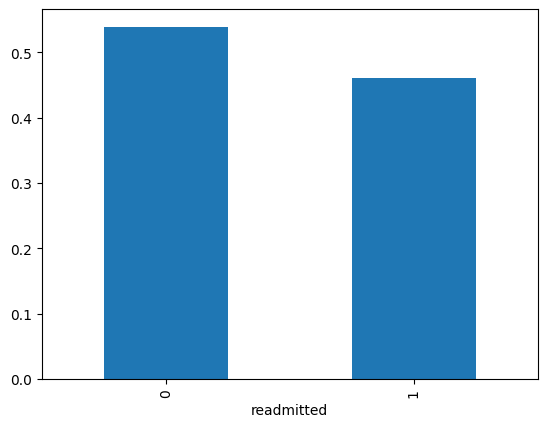

In [ ]:
view['readmitted'].value_counts(normalize=True).sort_index().plot.bar()

Classes now look more balanced.

## Which metric is more important, precision or recall?

In this context, false negatives are more important than false positives. In fact, if we say that a patient will be readmitted sooner or later even if he or she is wrong, a later test in the hospital will correct our prediction. If, on the other hand, we say that a patient will not be readmitted even if he or she is wrong, we may risk the patient's life. We can say that **in this context recall is more important than precision**.

## K-Nearest Neighbor classification

In [ ]:
cols = np.concatenate([[view.columns[0]], view.columns[9:-1]])
view = pd.get_dummies(view, columns=cols, drop_first=True, dtype=np.uint8)

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(view, test_size=0.25)

In [ ]:
print(len(train_set), len(test_set))

76322 25441


In [ ]:
from sklearn.neighbors import KNeighborsClassifier as KNN

knn_7 = KNN(n_neighbors=7)

In [ ]:
train_set['readmitted']

43890    1
54491    1
75712    1
7555     1
2904     0
        ..
38742    1
50447    0
53617    1
62737    1
72432    0
Name: readmitted, Length: 76322, dtype: int64

In [ ]:
knn_7.fit(train_set.drop(columns='readmitted'), train_set['readmitted'])

KNeighborsClassifier(n_neighbors=7)

In [ ]:
print("Accuracy sul training set: %0.2f" % knn_7.score(train_set.drop(columns='readmitted'), train_set['readmitted']))
print("Accuracy sul training set: %0.2f" % knn_7.score(test_set.drop(columns='readmitted'), test_set['readmitted']))

Accuracy sul training set: 0.69
Accuracy sul training set: 0.56


# Conclusions